In [1]:
import pandas as pd
from glob import glob

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from geoletrld.model import Geolet
from geoletrld.selectors import RandomSelector, MutualInformationSelector, SelectorPipeline, ClusteringSelector, \
    GapSelector
from geoletrld.utils import Trajectories, y_from_df
from geoletrld.partitioners import NoPartitioner, GeohashPartitioner, FeaturePartitioner, SlidingWindowPartitioner
from geoletrld.distances import (EuclideanDistance, InterpolatedTimeDistance, LCSSTrajectoryDistance, FrechetDistance,
                                 CaGeoDistance, MatchComputeDistance)
from sklearn_extra.cluster import KMedoids

In [9]:
def benchmark(df: pd.DataFrame):
    df = df[["tid", "y", "time", "lat", "lon"]]

    trajectories = Trajectories.from_DataFrame(df, latitude="lat", longitude="lon", time="time")
    y = y_from_df(df, tid_name="tid", y_name="y")

    X_train, X_test, y_train, y_test = train_test_split(list(trajectories), y, test_size=0.3, random_state=32,
                                                        stratify=y)

    X_train = Trajectories([(k, trajectories[k]) for k in X_train])
    X_test = Trajectories([(k, trajectories[k]) for k in X_test])

    classifier = Geolet(
        partitioner=SlidingWindowPartitioner(window_size=50, verbose=True),
        selector=SelectorPipeline(
            RandomSelector(k=1000),
            MutualInformationSelector(n_jobs=8, k=10, distance=InterpolatedTimeDistance(n_jobs=8), verbose=True),
            # GapSelector(k=10, n_jobs=10, distance=MatchComputeDistance(EuclideanDistance(), LCSSTrajectoryDistance())),
             #ClusteringSelector(
             #KMeans(n_clusters=5), #è sbagliato?, ma funziona stranamente bene
             #KMedoids(n_clusters=3, metric='precomputed'),# n_jobs=9
            # AffinityPropagation(affinity="precomputed"), agg=lambda x: -np.sum(x),
            # OPTICS(metric="precomputed"),
            # SpectralClustering(affinity="precomputed"), agg=lambda x: -np.sum(x), #non gira
            # distance=LCSSTrajectoryDistance(n_jobs=10, verbose=True)
             #)
        ),
        distance=InterpolatedTimeDistance(n_jobs=8, verbose=True),
        model_to_fit=RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=32),
        # model_to_fit=KMeans(n_clusters=2)
        verbose=True,
        
    ).fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred))

In [10]:
rename_map = {
    "vehicle_id": "tid",
    "class": "y"
}

df = pd.read_csv("../generation/sumo_stuff/Grid-Empire-2.5km/trajectories.zip").rename(columns=rename_map)

df.head()

,tid,lon,lat,time,y
0,veh0,-73.997363,40.761999,2.0,passenger
1,veh0,-73.997372,40.761964,3.0,passenger
2,veh0,-73.997404,40.761918,4.0,passenger
3,veh0,-73.997448,40.761859,5.0,passenger
4,veh0,-73.997503,40.761785,6.0,passenger
...,...,...,...,...,...
2259795,veh999,-73.966891,40.752557,1554.0,bicycle
2259796,veh999,-73.966865,40.752600,1555.0,bicycle
2259797,veh999,-73.966842,40.752643,1556.0,bicycle
2259798,veh999,-73.966821,40.752683,1557.0,bicycle


<Axes: >

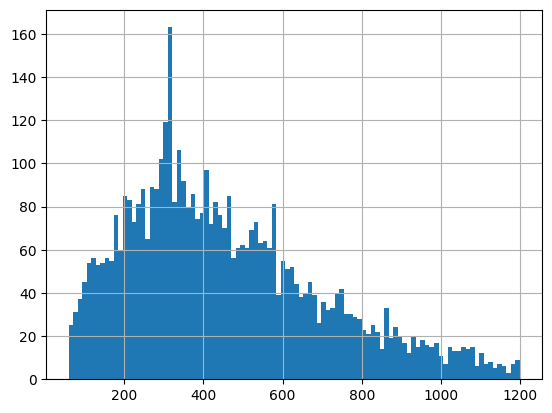

In [18]:
df_count = df.groupby("tid").size()
df_count = df_count[(df_count > 60) & (df_count < 60*20)]

df_count.hist(bins=100)


In [21]:
df[df.tid.isin(df_count.keys())]

,tid,lon,lat,time,y
0,veh0,-73.997363,40.761999,2.0,passenger
1,veh0,-73.997372,40.761964,3.0,passenger
2,veh0,-73.997404,40.761918,4.0,passenger
3,veh0,-73.997448,40.761859,5.0,passenger
4,veh0,-73.997503,40.761785,6.0,passenger
...,...,...,...,...,...
2259795,veh999,-73.966891,40.752557,1554.0,bicycle
2259796,veh999,-73.966865,40.752600,1555.0,bicycle
2259797,veh999,-73.966842,40.752643,1556.0,bicycle
2259798,veh999,-73.966821,40.752683,1557.0,bicycle
